    embed_dim  num_heads  ff_dim  lookback  \
0         128          5     256        20   
1         128          5     256        25   
2         128          5     512        20   
3         128          5     512        25   
4         128         10     256        20   
5         128         10     256        25   
6         128         10     512        20   
7         128         10     512        25   
8         256          5     256        20   
9         256          5     256        25   
10        256          5     512        20   
11        256          5     512        25   
12        256         10     256        20   
13        256         10     256        25   
14        256         10     512        20   
15        256         10     512        25   

                                              X_train  \
0   [[[0.9216867469879517, 0.9093406593406594, 0.9...   
1   [[[0.9216867469879517, 0.9093406593406594, 0.9...   
2   [[[0.9216867469879517, 0.9093406593406594,

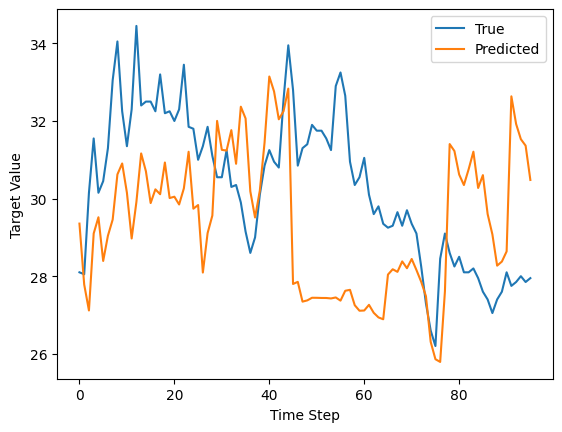

7.041412320488377
2.278612203833958


In [8]:
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import os

def grid_search(embed_dims, num_heads_values, ff_dims, data, features, lookbacks):
    results = []
    epochs = 200
    batch_size = 32

    for embed_dim, num_heads, ff_dim, lookback in product(embed_dims, num_heads_values, ff_dims, lookbacks):
        X_train, y_train, X_test, y_test, scaler = preprocess_data(data, features, lookback)
        model = build_model(embed_dim, num_heads, ff_dim, input_shape=X_train.shape[1:], rate=0.1)
        
        validation_loss = []

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
        validation_loss.append(history.history['val_loss'][-1])

        avg_validation_loss = np.mean(validation_loss)

        results.append({
            'embed_dim': embed_dim,
            'num_heads': num_heads,
            'ff_dim': ff_dim,
            'lookback': lookback,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'scaler': scaler,
            'validation_loss': avg_validation_loss
        })

    return results

def preprocess_data(data, features, lookback):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(lookback, len(data_scaled)):
        X.append(data_scaled[i-lookback:i])
        y.append(data_scaled[i][5])

    X, y = np.array(X), np.array(y)

    X_train, X_test = X[:-96], X[-96:]
    y_train, y_test = y[:-96], y[-96:]

    return X_train, y_train, X_test, y_test, scaler


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embedding = Dense(embed_dim, activation='linear')
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        inputs_embedded = self.embedding(inputs)
        attn_output = self.att(inputs_embedded, inputs_embedded)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs_embedded + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def build_model(embed_dim, num_heads, ff_dim, input_shape, rate=0.1):
    inputs = Input(shape=input_shape)
    x = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(inputs)
    x = Dense(30, activation='relu')(x[:, -1])
    x = Dropout(rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_predictions(y_test, y_pred):
    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()

def main():
    data = pd.read_csv('20MICRONS.csv')
    features = ['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']
    embed_dims = [128, 256]
    num_heads_values = [5, 10]
    ff_dims = [256, 512]
    lookback = [20, 25]
    epochs = 200
    batch_size = 32

    # Perform grid search
    results = grid_search(embed_dims, num_heads_values, ff_dims, data, features, lookback)
    results_df = pd.DataFrame(results)
    print(results_df)
    
    # Find the best hyperparameters based on validation loss
    best_hyperparams = results_df.loc[results_df['validation_loss'].idxmin()]
    print("Best hyperparameters:", best_hyperparams)
    
    X_train = best_hyperparams['X_train']
    y_train = best_hyperparams['y_train']
    X_test = best_hyperparams['X_test']
    y_test = best_hyperparams['y_test']
    scaler = best_hyperparams['scaler']

    # Train and evaluate model with the best hyperparameters
    best_model = build_model(best_hyperparams['embed_dim'], best_hyperparams['num_heads'], best_hyperparams['ff_dim'], input_shape=X_train.shape[1:], rate=0.1)
    best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

    history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

    y_pred = best_model.predict(X_test)
    y_pred = y_pred.reshape(-1, 1)  # Reshape y_pred to 2 dimensions
    y_pred = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], len(features) - 1))], axis=-1))[:, 0]
    y_test_unscaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))], axis=-1))[:, 0]
    
    print(y_test_unscaled)

    plot_predictions(y_test_unscaled, y_pred)
    print(mean_squared_error(y_pred, y_test_unscaled))
    print(mean_absolute_error(y_pred, y_test_unscaled))

if __name__ == "__main__":
    main()
